<a href="https://colab.research.google.com/github/VasundharaAgarwal/GANFingerprinting/blob/main/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import os
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torchvision
import pandas as pd
import torchvision.utils as vutils
import torch.nn as nn

import torch.nn.functional as F
import torch.optim as optim

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
!cp '/content/gdrive/My Drive/Diss/Yu/train_data.zip' '/content/train_data.zip'

In [4]:
!unzip 'train_data.zip'

Streaming output truncated to the last 5000 lines.
  inflating: train_data/gan_1_img_8523.npy  
  inflating: train_data/real_img_14663.npy  
  inflating: train_data/gan_2_img_1902.npy  
  inflating: train_data/gan_2_img_8098.npy  
  inflating: train_data/real_img_1576.npy  
  inflating: train_data/gan_1_img_3476.npy  
  inflating: train_data/gan_3_img_10996.npy  
  inflating: train_data/gan_3_img_9785.npy  
  inflating: train_data/real_img_432.npy  
  inflating: train_data/real_img_10405.npy  
  inflating: train_data/gan_3_img_7970.npy  
  inflating: train_data/gan_1_img_12422.npy  
  inflating: train_data/gan_3_img_11450.npy  
  inflating: train_data/gan_1_img_4319.npy  
  inflating: train_data/real_img_5710.npy  
  inflating: train_data/gan_1_img_5007.npy  
  inflating: train_data/gan_2_img_12180.npy  
  inflating: train_data/gan_1_img_14053.npy  
  inflating: train_data/gan_1_img_2768.npy  
  inflating: train_data/real_img_3361.npy  
  inflating: train_data/gan_1_img_3462.npy  
  in

In [17]:
import sys
sys.path.append('/content/gdrive/My Drive/')
import model_architectures as ma

In [24]:
netG1 = ma.Generator1(0)
model_dict1 = torch.load('/content/gdrive/My Drive/Diss/trained_models/GAN_1', map_location=torch.device('cpu'))
netG1.load_state_dict(model_dict1['G_state_dict'])

netG2 = ma.Generator2(0)
model_dict2 = torch.load('/content/gdrive/My Drive/Diss/trained_models/GAN_2', map_location=torch.device('cpu'))
netG2.load_state_dict(model_dict2['G_state_dict'])

netG3 = ma.Generator3(0)
model_dict3 = torch.load('/content/gdrive/My Drive/Diss/trained_models/GAN_3', map_location=torch.device('cpu'))
netG3.load_state_dict(model_dict3['G_state_dict'])

real_train_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('/files/', train=True, download=True, transform=torchvision.transforms.ToTensor()), batch_size=15000)
real_images, _ = next(iter(real_train_loader))

Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw



Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw


Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw


Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw
Processing...
Done!




/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [19]:
netG1 = ma.Generator1(0)
model_dict1 = torch.load('/content/gdrive/My Drive/Diss/trained_models/GAN_1', map_location=torch.device('cpu'))
netG1.load_state_dict(model_dict1['G_state_dict'])
noise = torch.randn(2,100,1,1)
netG1(noise).view(-1).shape

torch.Size([1568])

In [ ]:

for i in range(15000):
  if i%100 == 0:
    print(i)
  noise = torch.randn(100,1,1)
  np.save('/content/gdrive/My Drive/Diss/Yu/train_data/real_img_{}.npy'.format(i+1), real_images[i].numpy())
  img_to_labels_dict['real_img_{}'.format(i+1)] = 0
  np.save('/content/gdrive/My Drive/Diss/Yu/train_data/gan_1_img_{}.npy'.format(i+1), netG1(noise).detach().numpy())
  img_to_labels_dict['gan_1_img_{}'.format(i+1)] = 1
  np.save('/content/gdrive/My Drive/Diss/Yu/train_data/gan_2_img_{}.npy'.format(i+1), netG2(noise).detach().numpy())
  img_to_labels_dict['gan_2_img_{}'.format(i+1)] = 1
  np.save('/content/gdrive/My Drive/Diss/Yu/train_data/gan_3_img_{}.npy'.format(i+1), netG3(noise).detach().numpy())
  img_to_labels_dict['gan_3_img_{}'.format(i+1)] = 1

In [2]:
partition = {}
partition['training data'] = ['{}_img_{}'.format(source, num) for source in ['gan_1','gan_2','gan_3','real'] for num in range(1,10001)]
partition['validation data'] = ['{}_img_{}'.format(source, num) for source in ['gan_1','gan_2','gan_3','real'] for num in range(10001,15001)]

In [3]:
img_to_labels_dict = {}
label_mapping = {'real':0, 'gan_1':1, 'gan_2':2, 'gan_3':3}
for num in range(1,150001):
  for source in label_mapping.keys():
    img_to_labels_dict['{}_img_{}'.format(source,num)] = label_mapping[source]

In [4]:
class AutoEncoderDataset(torch.utils.data.Dataset):
  def __init__(self, list_IDs, labels):
        self.labels = labels
        self.list_IDs = list_IDs

  def __len__(self):
        return len(self.list_IDs)

  def __getitem__(self, index):
        ID = self.list_IDs[index]
        img = torch.from_numpy(np.load('/content/train_data/' + ID + '.npy'))
      
        label = self.labels[ID]

        return img, label

In [5]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        #encoder 
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        self.maxPool = nn.MaxPool2d(2, 2)  
       
        # decoder 
        self.convTr1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.convTr2 = nn.ConvTranspose2d(16, 1, 2, stride=2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.maxPool(x)
        x = F.relu(self.conv2(x))
        x = self.maxPool(x)  
        x = F.relu(self.convTr1(x))
        x = F.sigmoid(self.convTr2(x))
                
        return x



In [84]:
def custom_loss(output, target, source):
  output_1d_vec = output.view(-1)
  target_1d_vec = target.view(-1)
  mseCriterion = nn.MSELoss()
  mse_loss = mseCriterion(output_1d_vec, target_1d_vec)
  output_vec = torch.reshape(output, (-1, 784)) #flatten batch of matrices to batch of vectors
  target_vec = torch.reshape(target, (-1, 784)) #flatten batch of matrices to batch of vectors
  img_fps_vec = output_vec - target_vec      #get fingerprint
  img_fps_vec_norm = F.normalize(img_fps_vec - torch.mean(img_fps_vec, dim=1).unsqueeze(1), dim=1) #normalize fingerprint for each image in batch
  fps_vec_norm = [F.normalize(fp - torch.mean(fp), dim=0) for fp in fps] #normalize each model fingerprint
  cov_vecs = [(torch.mv(img_fps_vec_norm, fp_vec_norm)) for fp_vec_norm in fps_vec_norm] #get covariance of each image with each fingerprint
  ce_loss_criterion = nn.CrossEntropyLoss()
  ce_loss = ce_loss_criterion(torch.stack(cov_vecs, dim=1), source) 
  return ce_loss + 5*mse_loss
  




In [85]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
autoEnc = Autoencoder()
autoEnc.to(device)


Autoencoder(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxPool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (convTr1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (convTr2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
)

In [86]:
real_fp = torch.randn(784, requires_grad=True, device=device)
gan1_fp = torch.randn(784, requires_grad=True, device=device)
gan2_fp = torch.randn(784, requires_grad=True, device=device)
gan3_fp = torch.randn(784, requires_grad=True, device = device)
fps = [real_fp, gan1_fp, gan2_fp, gan3_fp]

In [87]:
from itertools import chain
optimizer = optim.Adam(chain(autoEnc.parameters(), iter(fps)))

In [88]:
params = {'batch_size': 256,
          'shuffle': True,
          'num_workers': 6}
max_epochs = 20


training_set = AutoEncoderDataset(partition['training data'], img_to_labels_dict)
training_generator = torch.utils.data.DataLoader(training_set, **params)

validation_set = AutoEncoderDataset(partition['validation data'], img_to_labels_dict)
validation_generator = torch.utils.data.DataLoader(validation_set, **params)

In [89]:
train_losses = []
val_losses = []
for epoch in range(max_epochs):
  print("Starting epoch {}".format(epoch))
    # Training
  for i, (local_batch, local_labels) in enumerate(training_generator):
      local_batch, local_labels = local_batch.to(device), local_labels.to(device)
      optimizer.zero_grad()
      output = autoEnc(local_batch)
      loss = custom_loss(output, local_batch, local_labels)
      loss.backward()
      optimizer.step()

      if i % 50 == 0:
        print('[%d/%d][%d/%d]\tTrain Loss %.4f'
        % (epoch, max_epochs, i, len(training_generator),loss.item()))
    
  train_losses.append(loss.item())

  # Validation
  loss_sum = 0
  with torch.set_grad_enabled(False):
      for local_batch, local_labels in validation_generator:
          local_batch, local_labels = local_batch.to(device), local_labels.to(device)
          output = autoEnc(local_batch)
          loss = custom_loss(output, local_batch, local_labels)
          loss_sum += loss.item()
  avg_val_loss = loss_sum/len(validation_generator)
  print("Val Loss %.4f"%(avg_val_loss))
  val_losses.append(avg_val_loss)

Starting epoch 0


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[0/20][0/157]	Train Loss 3.0391
[0/20][50/157]	Train Loss 2.6577
[0/20][100/157]	Train Loss 2.0514
[0/20][150/157]	Train Loss 1.8108
Val Loss 1.7741
Starting epoch 1
[1/20][0/157]	Train Loss 1.7712
[1/20][50/157]	Train Loss 1.6295
[1/20][100/157]	Train Loss 1.5981
[1/20][150/157]	Train Loss 1.5863
Val Loss 1.5810
Starting epoch 2
[2/20][0/157]	Train Loss 1.5762
[2/20][50/157]	Train Loss 1.5575
[2/20][100/157]	Train Loss 1.5568
[2/20][150/157]	Train Loss 1.5384
Val Loss 1.5310
Starting epoch 3
[3/20][0/157]	Train Loss 1.5325
[3/20][50/157]	Train Loss 1.4884
[3/20][100/157]	Train Loss 1.4740
[3/20][150/157]	Train Loss 1.4645
Val Loss 1.4674
Starting epoch 4
[4/20][0/157]	Train Loss 1.4660
[4/20][50/157]	Train Loss 1.4589
[4/20][100/157]	Train Loss 1.4555
[4/20][150/157]	Train Loss 1.4594
Val Loss 1.4560
Starting epoch 5
[5/20][0/157]	Train Loss 1.4572
[5/20][50/157]	Train Loss 1.4546
[5/20][100/157]	Train Loss 1.4485
[5/20][150/157]	Train Loss 1.4519
Val Loss 1.4487
Starting epoch 6
[6/2

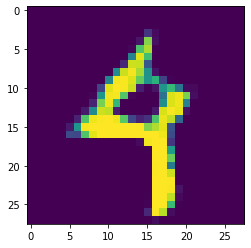

In [94]:
img = np.load('train_data/gan_1_img_3.npy')
plt.imshow(img.reshape(28,28))

In [95]:
img_ten = torch.from_numpy(img).reshape(1,1,28,28).to(device)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


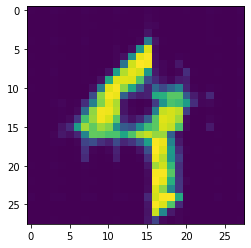

In [96]:
plt.imshow(autoEnc(img_ten).to('cpu').detach().numpy().reshape(28,28))

In [98]:
torch.save({
            'model_state_dict': autoEnc.state_dict(),
            'optim_state_dict': optimizer.state_dict(),
            'train_losses': train_losses,
            'val_losses':val_losses
            }, 'gdrive/My Drive/Diss/trained_models/Autoencoder')

In [106]:
np.save('gdrive/My Drive/Diss/Yu/Fingerprints/print_real', real_fp.to('cpu').detach().numpy())
np.save('gdrive/My Drive/Diss/Yu/Fingerprints/print_GAN_1', gan1_fp.to('cpu').detach().numpy())
np.save('gdrive/My Drive/Diss/Yu/Fingerprints/print_GAN_2', gan2_fp.to('cpu').detach().numpy())
np.save('gdrive/My Drive/Diss/Yu/Fingerprints/print_GAN_3', gan3_fp.to('cpu').detach().numpy())